In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import xception
from keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
path_training='drive/My Drive/Semester 6/Deep Learning A/Data/train/'
path_valid='drive/My Drive/Semester 6/Deep Learning A/Data/valid/'
path_test='drive/My Drive/Semester 6/Deep Learning A/Data/test/'

In [ ]:
data_generator=ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_batches = data_generator.flow_from_directory(
    path_training, target_size=(299,299), batch_size=10)
valid_batches = data_generator.flow_from_directory(
    path_valid, target_size=(299,299), batch_size=15)
test_batches = data_generator.flow_from_directory(
    path_test, target_size=(299,299), batch_size=40)

Found 2097 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D,Dropout
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model

In [ ]:
# creating the Conv-Batch Norm block

def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    return x

# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    return x



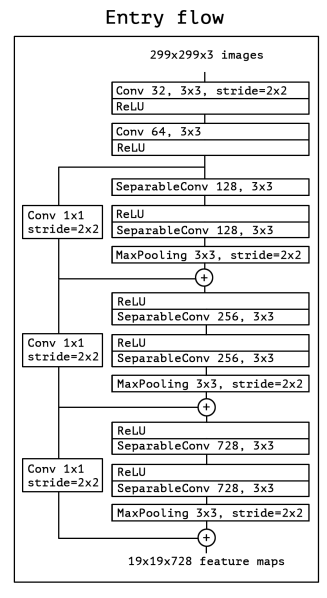

In [ ]:
# entry flow

def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x


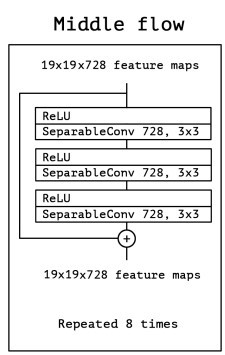

In [ ]:
# middle flow
def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
    return tensor

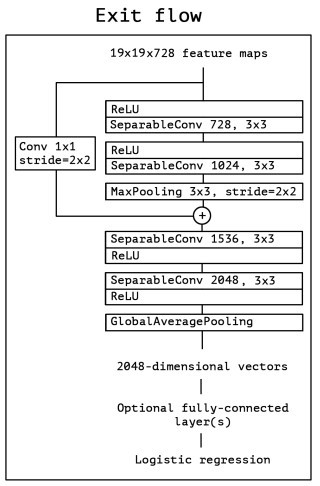

---



In [ ]:
# exit flow

def exit_flow(tensor):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dropout(0.2)(x)
    x = Dense (5, activation = 'softmax')(x)
    
    return x

In [ ]:
# Custom Early Stopping
# Expected behavior: EarlyStopping should restore weights on end of training regardless it stop training early or after the last epoch

class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_val_loss = np.Inf
        self.best_loss = np.Inf
        self.best_val_accuracy = 0.0
        self.best_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None): 
        val_loss = logs.get('val_loss')
        loss = logs.get('loss')
        val_accuracy = logs.get('val_accuracy')
        accuracy = logs.get('accuracy')

        # if np.less(val_loss, self.best_val_loss) and np.greater(map10, self.best_map10):
        if np.greater_equal(val_accuracy, self.best_val_accuracy) and np.greater_equal(accuracy, self.best_accuracy) and np.greater_equal(accuracy, val_accuracy) and abs(val_loss - loss) < 0.5 and val_loss > loss:
            self.best_val_loss = val_loss
            self.best_loss = loss
            self.best_val_accuracy = val_accuracy
            self.best_accuracy = accuracy
            self.wait = 0

            # Record the best weights if current results is better.
            print("Saving the best weight at epoch {}".format(epoch + 1))
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Training stop early. Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
                
    def on_train_end(self, logs=None):
        # EarlyStopping will restore weights after the last epoch only if it is not stop early
        if self.stopped_epoch > 0:
            print("Epoch {}: early stopping".format(self.stopped_epoch + 1))
        else:
            print("Training stop after the last epoch. Restoring model weights from the end of the best epoch.")
            self.model.set_weights(self.best_weights)

In [79]:
# model code
 
input = Input(shape = (299,299,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

final_model = Model (inputs=input, outputs=output)
final_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_83 (Conv2D)             (None, 150, 150, 32  864         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_555 (Batch  (None, 150, 150, 32  128        ['conv2d_83[0][0]']              
 Normalization)                 )                                                          

In [86]:
final_model.compile(RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1, restore_best_weights=True),
    CustomEarlyStopping(patience=50),
    #tf.keras.callbacks.ModelCheckpoint(filepath='batik-recognition-model.{epoch:03d}.hdf5',  monitor='val_accuracy', mode='max', verbose=0, save_best_only=False),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = final_model.fit(train_batches, steps_per_epoch=8,batch_size=64, validation_data=valid_batches, validation_steps=8, epochs=50, verbose=2,callbacks=my_callbacks)

Epoch 1/50
8/8 - 5s - loss: 7.8167 - accuracy: 0.2000 - val_loss: 1.6363 - val_accuracy: 0.1917 - 5s/epoch - 655ms/step
Epoch 2/50
8/8 - 4s - loss: 3.7283 - accuracy: 0.2875 - val_loss: 1.6036 - val_accuracy: 0.2000 - 4s/epoch - 555ms/step
Epoch 3/50
8/8 - 5s - loss: 2.2927 - accuracy: 0.2500 - val_loss: 1.6021 - val_accuracy: 0.2500 - 5s/epoch - 571ms/step
Epoch 4/50
8/8 - 5s - loss: 1.8021 - accuracy: 0.2125 - val_loss: 1.6090 - val_accuracy: 0.2500 - 5s/epoch - 570ms/step
Epoch 5/50
8/8 - 4s - loss: 1.6828 - accuracy: 0.2375 - val_loss: 1.6116 - val_accuracy: 0.1833 - 4s/epoch - 548ms/step
Epoch 6/50
8/8 - 5s - loss: 1.9633 - accuracy: 0.2750 - val_loss: 1.6164 - val_accuracy: 0.1917 - 5s/epoch - 573ms/step
Epoch 7/50
8/8 - 4s - loss: 1.7003 - accuracy: 0.3375 - val_loss: 1.6128 - val_accuracy: 0.2417 - 4s/epoch - 544ms/step
Epoch 8/50
8/8 - 4s - loss: 2.1802 - accuracy: 0.2750 - val_loss: 1.6138 - val_accuracy: 0.1833 - 4s/epoch - 539ms/step
Epoch 9/50
8/8 - 5s - loss: 2.1063 - acc

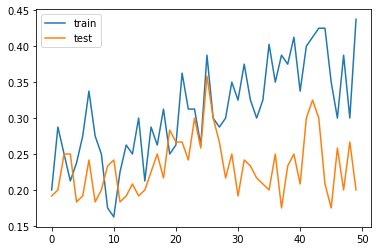

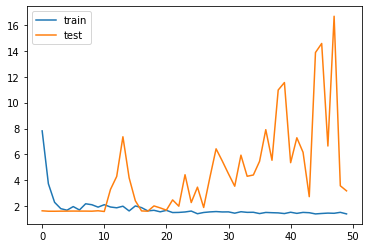

In [89]:
# plot learning curves of accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
# plot learning curves of model loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [90]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from keras.preprocessing import image  
from keras.applications.xception import preprocess_input
from tqdm import tqdm

def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_files, test_targets = load_dataset(path_test)
test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 200/200 [00:01<00:00, 100.81it/s]


In [91]:
#evaluate and print test accuracy
score = final_model.evaluate(test_tensors, test_targets) 
print('\n', 'Test accuracy:', score[1])

7/7 [==============================] - 3s 216ms/step - loss: 2.2445 - accuracy: 0.2750

 Test accuracy: 0.2750000059604645


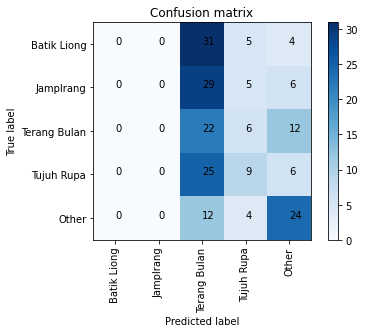

In [92]:
from sklearn.metrics import confusion_matrix

cm_labels = ['Batik Liong','Jamplrang', 'Terang Bulan', 'Tujuh Rupa','Other']

cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(final_model.predict(test_tensors), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

## **Data Augmentation**

In [101]:
data_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=xception.preprocess_input,
    rescale=1./127.5-1.,
)

train_batches = data_generator.flow_from_directory(
    path_training, target_size=(299,299), batch_size=10)
valid_batches = data_generator.flow_from_directory(
    path_valid, target_size=(299,299), batch_size=15)
test_batches = data_generator.flow_from_directory(
    path_test, target_size=(299,299), batch_size=40)

Found 2097 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


In [102]:
# model code
 
input = Input(shape = (299,299,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

final_model = Model (inputs=input, outputs=output)
final_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 150, 150, 32  864         ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_635 (Batch  (None, 150, 150, 32  128        ['conv2d_95[0][0]']              
 Normalization)                 )                                                          

In [103]:
final_model.compile(RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [104]:
my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1, restore_best_weights=True),
    CustomEarlyStopping(patience=50),
    #tf.keras.callbacks.ModelCheckpoint(filepath='batik-recognition-model.{epoch:03d}.hdf5',  monitor='val_accuracy', mode='max', verbose=0, save_best_only=False),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = final_model.fit(train_batches, steps_per_epoch=8,batch_size=64, validation_data=valid_batches, validation_steps=8, epochs=50, verbose=2,callbacks=my_callbacks)

Epoch 1/50
8/8 - 16s - loss: 6.4525 - accuracy: 0.2125 - val_loss: 1.6113 - val_accuracy: 0.2000 - 16s/epoch - 2s/step
Epoch 2/50
8/8 - 9s - loss: 2.6341 - accuracy: 0.1375 - val_loss: 1.6161 - val_accuracy: 0.2000 - 9s/epoch - 1s/step
Epoch 3/50
8/8 - 9s - loss: 2.1252 - accuracy: 0.1818 - val_loss: 1.6094 - val_accuracy: 0.2250 - 9s/epoch - 1s/step
Epoch 4/50
8/8 - 7s - loss: 2.0368 - accuracy: 0.2250 - val_loss: 1.6168 - val_accuracy: 0.1500 - 7s/epoch - 865ms/step
Epoch 5/50
8/8 - 9s - loss: 2.0494 - accuracy: 0.2125 - val_loss: 1.6163 - val_accuracy: 0.2167 - 9s/epoch - 1s/step
Epoch 6/50
8/8 - 9s - loss: 2.2892 - accuracy: 0.1250 - val_loss: 1.6127 - val_accuracy: 0.2000 - 9s/epoch - 1s/step
Epoch 7/50
8/8 - 7s - loss: 1.8082 - accuracy: 0.2250 - val_loss: 1.6422 - val_accuracy: 0.1417 - 7s/epoch - 906ms/step
Epoch 8/50
8/8 - 9s - loss: 1.9286 - accuracy: 0.1500 - val_loss: 1.6240 - val_accuracy: 0.2167 - 9s/epoch - 1s/step
Epoch 9/50
8/8 - 9s - loss: 1.8079 - accuracy: 0.2375 - 

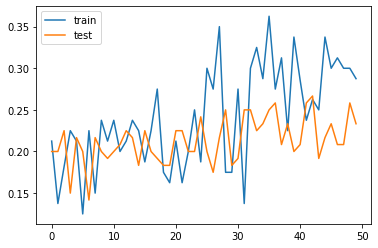

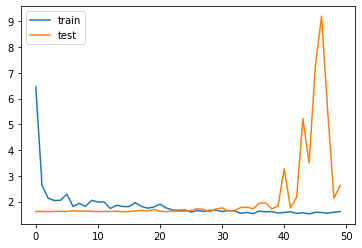

In [105]:
# plot learning curves of accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
# plot learning curves of model loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [106]:
#evaluate and print test accuracy
score = final_model.evaluate(test_tensors, test_targets) 
print('\n', 'Test accuracy:', score[1])

7/7 [==============================] - 2s 204ms/step - loss: 2.0839 - accuracy: 0.2550

 Test accuracy: 0.2549999952316284


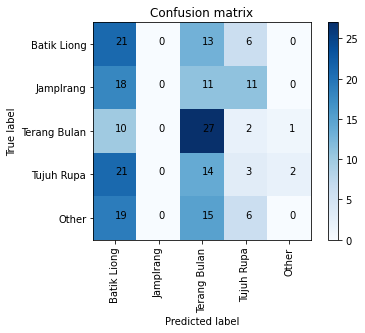

In [107]:
from sklearn.metrics import confusion_matrix

cm_labels = ['Batik Liong','Jamplrang', 'Terang Bulan', 'Tujuh Rupa','Other']

cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(final_model.predict(test_tensors), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()